In [126]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns

In [127]:
def load_data(path_data = 'dataset/'):    
    data = []
    labels = []
    file_name = []
    
    for sub_folder in os.listdir(path_data):
        sub_folder_files = os.listdir(os.path.join(path_data, sub_folder))
        for i, filename in enumerate(sub_folder_files):
            img_path = os.path.join(path_data, sub_folder, filename)
            
            img = cv.imread(img_path)
            img = img.astype(np.uint8)
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            img = cv.resize(img, (300, 300))
            
            data.append(img)
            labels.append(sub_folder)
            file_name.append(filename)
            
    print(len(data), len(labels), len(file_name))
    return data, labels, file_name


In [128]:
data, labels, file_name = load_data('dataset/')

300 300 300


In [129]:
from augmen import ImageAugmentor
output_path = 'augment/'
augmentor = ImageAugmentor(data, labels, file_name, 'augment')
augmentor.augment_data()
data, labels, file_name = load_data('augment/')

600 600 600


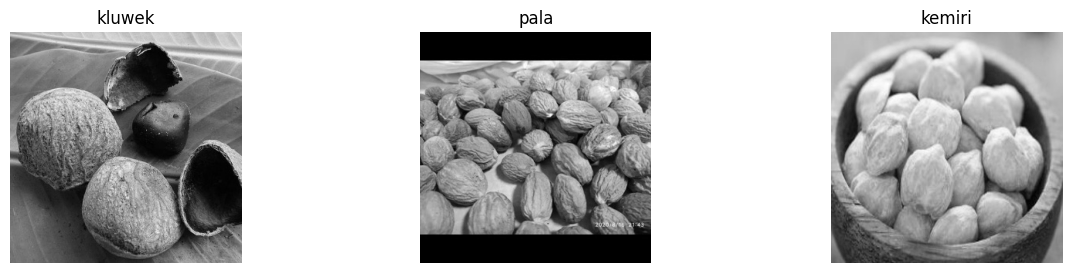

In [130]:
sample_data = []
sample_labels = []
for label in set(labels):
    idx = labels.index(label)
    sample_data.append(data[idx])
    sample_labels.append(labels[idx])

# Display the samples using matplotlib.pyplot
fig, axs = plt.subplots(1, len(set(labels)), figsize=(15, 3))
for i, (img, label) in enumerate(zip(sample_data, sample_labels)):
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(label)
    axs[i].axis('off')
plt.show()

In [131]:
def tresholding(img, treshold):
    img[img < treshold] = 0
    img[img >= treshold] = 255
    return img

def normalize(img):
	img = img.astype(np.float32)
	img = (img - img.min()) / (img.max() - img.min())
	img = (img * 255).astype(np.uint8)
	return img

In [132]:
from skimage.filters import prewitt, unsharp_mask
from skimage.morphology import closing, skeletonize
dataPreprocessed = []
for i in range(len(data)):
    image = data[i]
    image = prewitt(image)
    image = normalize(image)
    image = tresholding(image, 45)
    image = unsharp_mask(image, radius=1.0, amount=1.0)  # Langkah sharpening
    image = skeletonize(image)
    image = closing(image, np.ones((3, 3)))
    dataPreprocessed.append(image)

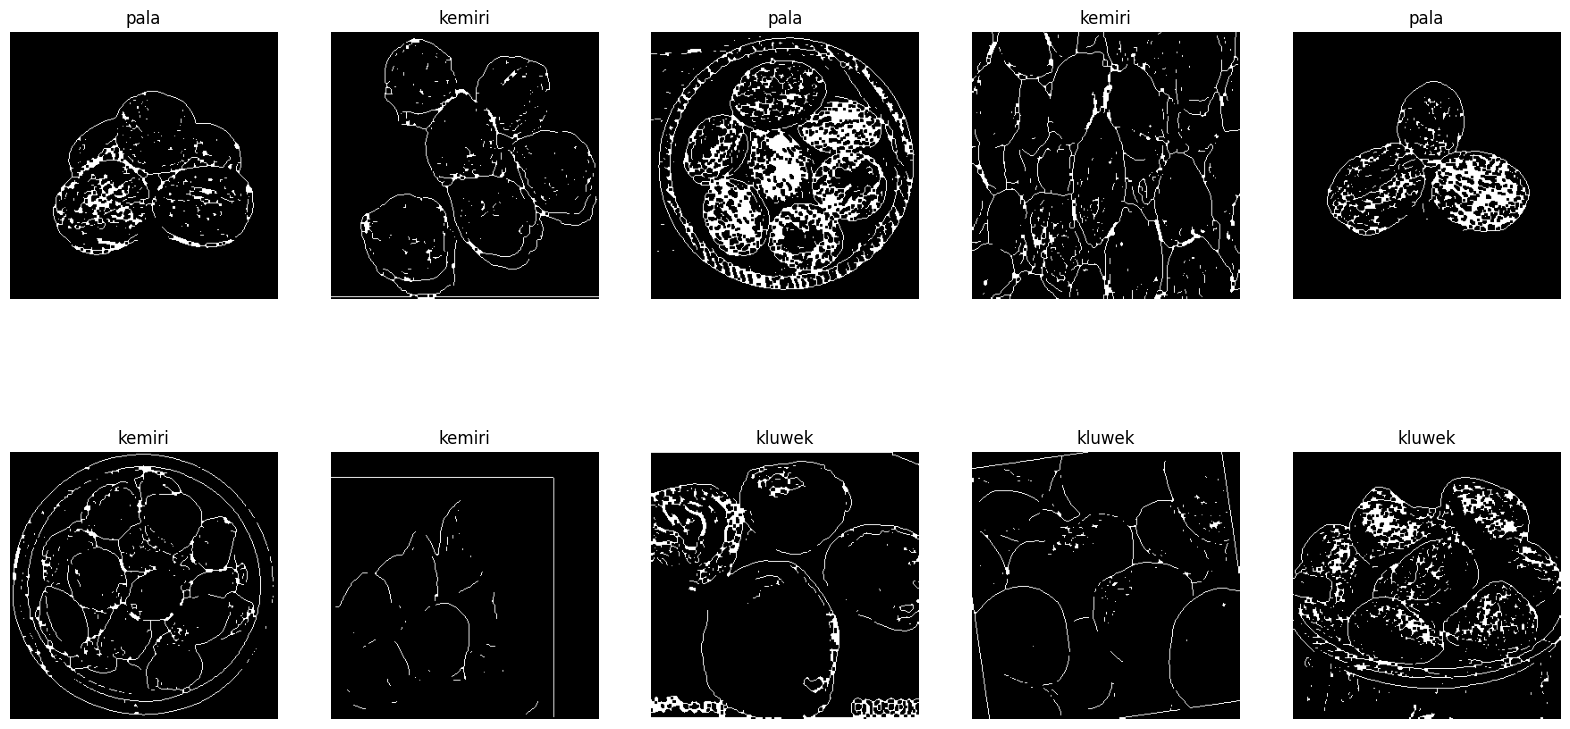

In [133]:
import random as rand

# show 10 random image
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(2):
	for j in range(5):
		rand_index = rand.randint(0, len(dataPreprocessed))
		ax[i, j].imshow(dataPreprocessed[rand_index], cmap='gray')
		ax[i, j].set_title(labels[rand_index])
		ax[i, j].axis('off')
plt.show()

In [134]:
def glcm(image, derajat):
    directions = {
        0: (0, 1),
        45: (-1, 1),
        90: (-1, 0),
        135: (-1, -1)
    }
    if derajat not in directions:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    d = directions[derajat]
    max_val = 256
    glcm = np.zeros((max_val, max_val))
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if 0 <= i + d[0] < image.shape[0] and 0 <= j + d[1] < image.shape[1]:
                glcm[image[i, j], image[i + d[0], j + d[1]]] += 1

    glcm /= glcm.sum()
    return glcm

def calc_properties(glcm):
    I, J = np.ogrid[0:glcm.shape[0], 0:glcm.shape[1]]
    contrast = np.sum(glcm * (I - J) ** 2)
    dissimilarity = np.sum(glcm * np.abs(I - J))
    homogeneity = np.sum(glcm / (1.0 + (I - J) ** 2))
    ASM = np.sum(glcm ** 2)
    energy = np.sqrt(ASM)
    entropy = -np.sum(glcm * np.log2(glcm + (glcm == 0)))
    mean_i = np.sum(I * glcm)
    mean_j = np.sum(J * glcm)
    std_i = np.sqrt(np.sum((I - mean_i) ** 2 * glcm))
    std_j = np.sqrt(np.sum((J - mean_j) ** 2 * glcm))
    correlation = np.sum(((I - mean_i) * (J - mean_j) * glcm) / (std_i * std_j + (std_i * std_j == 0)))
    
    return contrast, dissimilarity, homogeneity, ASM, energy, entropy, correlation

# Data processing
angles = [0, 45, 90, 135]
properties = ["Contrast", "Dissimilarity", "Homogeneity", "ASM", "Energy", "Entropy", "Correlation"]
results = {f"{prop}{angle}": [] for angle in angles for prop in properties}

for img in data:
    for angle in angles:
        glcm_matrix = glcm(img, angle)
        props = calc_properties(glcm_matrix)
        for prop, value in zip(properties, props):
            results[f"{prop}{angle}"].append(value)

dataTable = {'Filename': file_name, 'Label': labels}
dataTable.update(results)

df = pd.DataFrame(dataTable)
df.to_csv('hasilEkstraksi.csv', index=False)

hasilEkstrak = pd.read_csv('hasilEkstraksi.csv')

<Axes: >

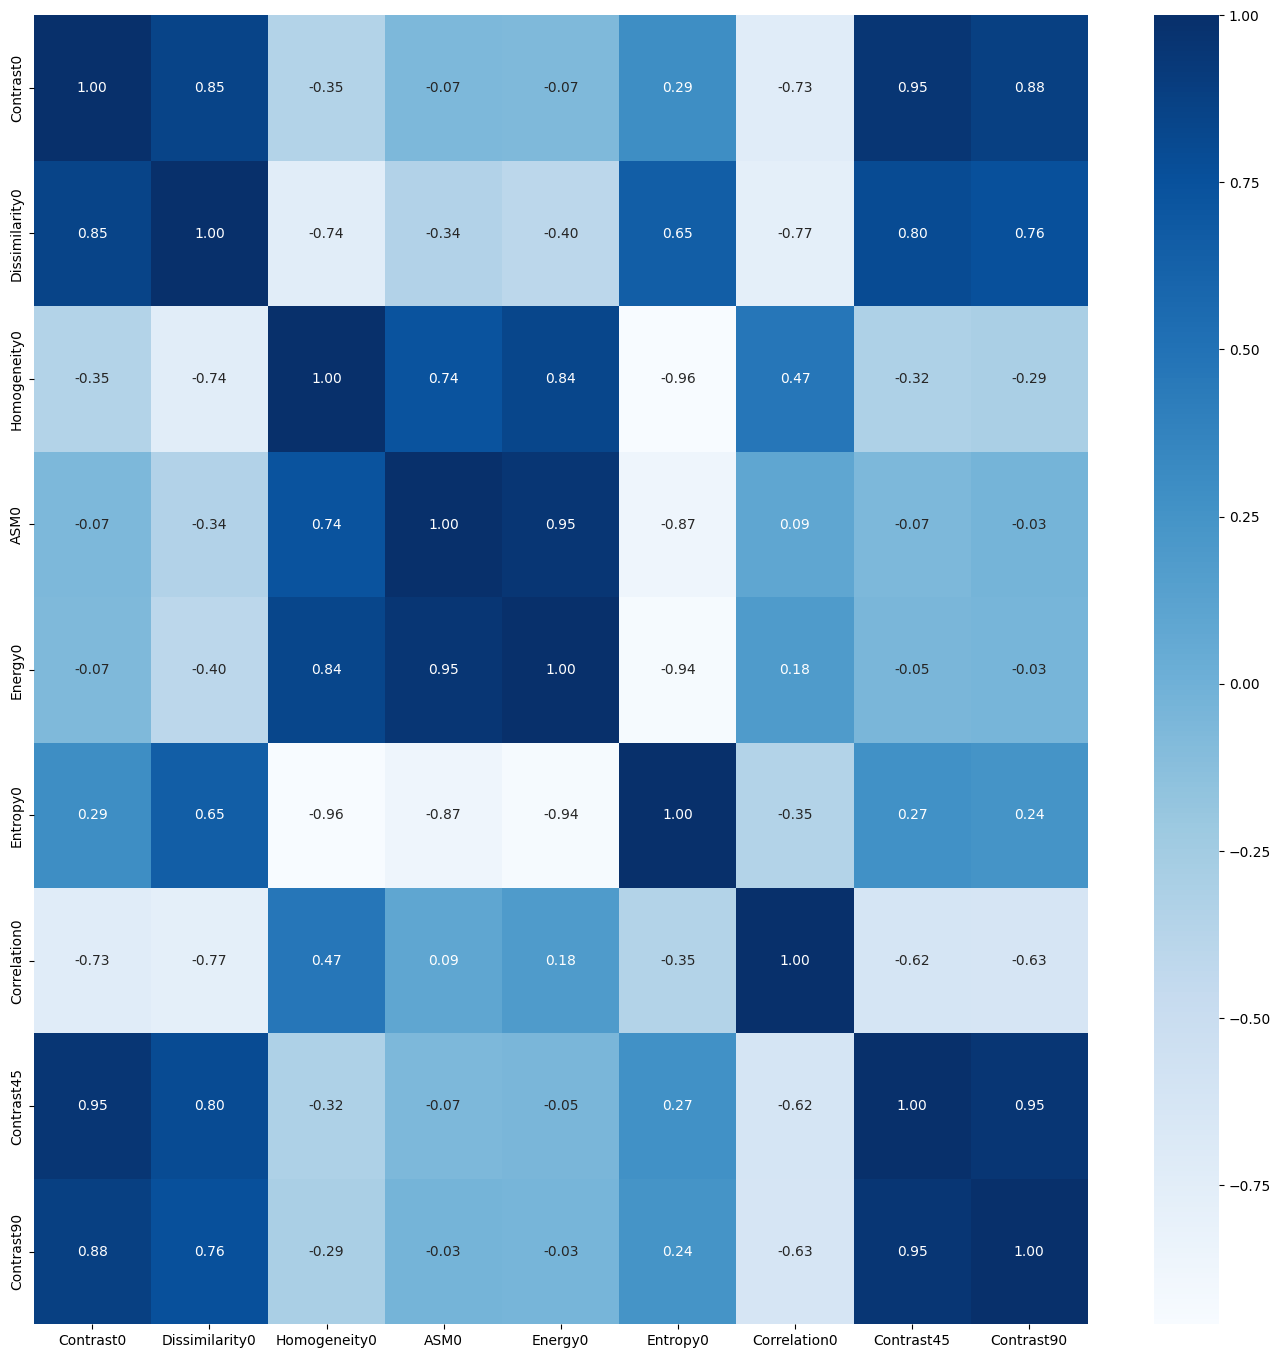

In [135]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

In [136]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train)
print(X_test)

      Contrast0  Dissimilarity0  Homogeneity0      ASM0   Energy0   Entropy0  \
108   11.019989        1.898227      0.503859  0.005904  0.076834   9.870015   
272  282.328941       12.244861      0.090514  0.000159  0.012627  13.152766   
599   18.827915        1.847670      0.668351  0.183727  0.428634   6.753135   
479   78.490680        3.691282      0.462600  0.064477  0.253923   8.990070   
436  345.752219        6.649097      0.723884  0.470838  0.686177   4.911431   
..          ...             ...           ...       ...       ...        ...   
71   122.111550        4.376812      0.538949  0.116973  0.342013   8.275186   
106   17.821048        2.499197      0.410069  0.001219  0.034909  10.750867   
270   78.067904        4.333790      0.428700  0.049717  0.222972   9.951337   
435  136.872664        6.767113      0.269656  0.009381  0.096854  11.497362   
102  115.376867        2.941237      0.519434  0.016382  0.127991   9.653876   

     Correlation0  Contrast45  Contrast

In [137]:
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [138]:
def crossValidation(x, y, model):
    y_pred = cross_val_predict(model, x, y, cv=20)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro', zero_division=1)
    recall = recall_score(y, y_pred, average='macro')
    f1 = f1_score(y, y_pred, average='macro')
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')
    return y_pred, accuracy, precision, recall, f1


print("KNN")
y_pred_knn, akurasiKNN, presisiKNN, recallKNN, f1KNN = crossValidation(x_new, y, KNeighborsClassifier(n_neighbors=20))

print("\nRandom Forest")
y_pred_rforest, akurasiRForest, presisiRForest, recallRForest, f1RForest = crossValidation(x_new, y, RandomForestClassifier(n_estimators=175, random_state=42))

print("\nSVM")
y_pred_svm, akurasiSVM, presisiSVM, recallSVM, f1SVM = crossValidation(x_new, y, SVC(kernel='rbf', random_state=42))

KNN
Accuracy: 50.00%
Precision: 50.46%
Recall: 50.00%
F1 Score: 50.21%

Random Forest
Accuracy: 59.67%
Precision: 59.70%
Recall: 59.67%
F1 Score: 59.55%

SVM
Accuracy: 47.33%
Precision: 46.09%
Recall: 47.33%
F1 Score: 46.19%


In [139]:
from sklearn.metrics import confusion_matrix

# KNN
y_pred_knn = crossValidation(x_new, y, KNeighborsClassifier(n_neighbors=20))[0]
conf_mat_knn = confusion_matrix(y, y_pred_knn)

# Random Forest
y_pred_rforest = crossValidation(x_new, y, RandomForestClassifier(n_estimators=175, random_state=42))[0]
conf_mat_rforest = confusion_matrix(y, y_pred_rforest)

# SVM
y_pred_svm = crossValidation(x_new, y, SVC(kernel='rbf', random_state=42))[0]
conf_mat_svm = confusion_matrix(y, y_pred_svm)

Accuracy: 50.00%
Precision: 50.46%
Recall: 50.00%
F1 Score: 50.21%
Accuracy: 59.67%
Precision: 59.70%
Recall: 59.67%
F1 Score: 59.55%
Accuracy: 47.33%
Precision: 46.09%
Recall: 47.33%
F1 Score: 46.19%


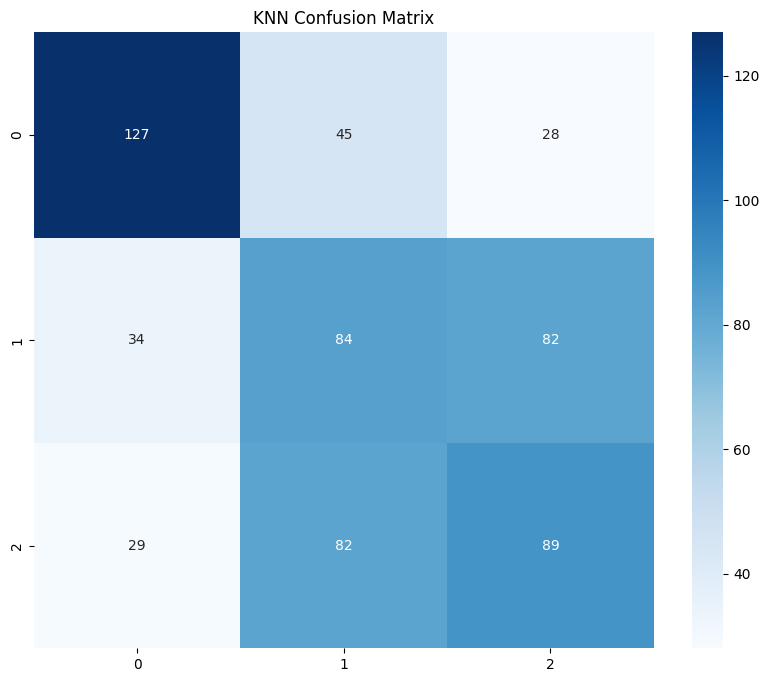

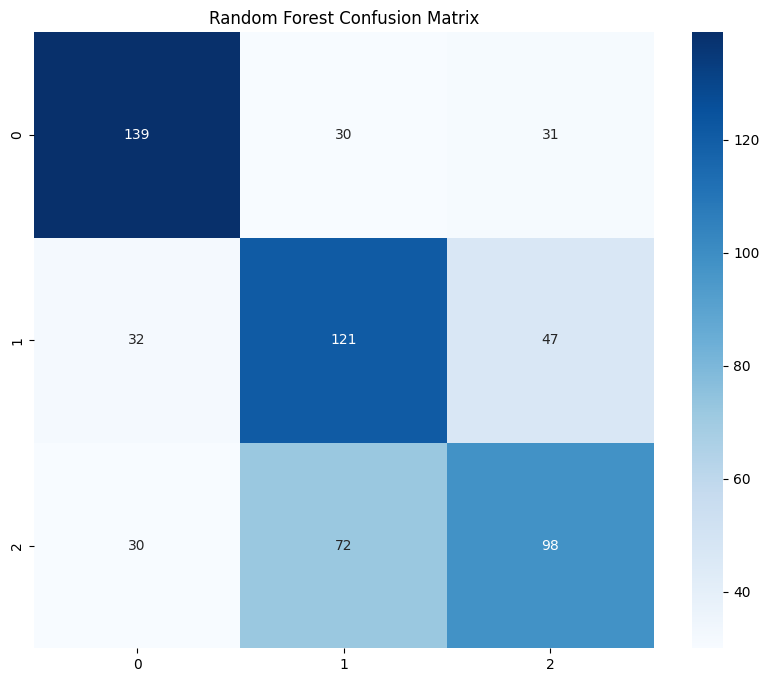

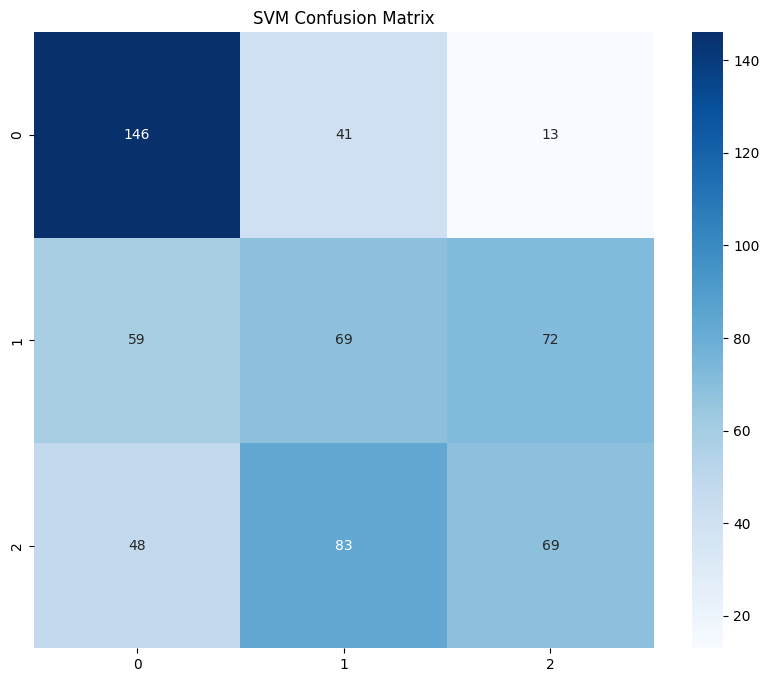

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_knn, annot=True, cmap="Blues", fmt="d")
plt.title("KNN Confusion Matrix")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_rforest, annot=True, cmap="Blues", fmt="d")
plt.title("Random Forest Confusion Matrix")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_svm, annot=True, cmap="Blues", fmt="d")
plt.title("SVM Confusion Matrix")
plt.show()
